## Chapter 32 Project: Monthly Sales of French Champagne

### Overview
1. Problem Description
2. Test Harness
3. Persistence
4. Data Analysis
5. ARIMA Models
6. Model Validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#### 1. Problem Description

The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France). The dataset provides the number of monthly sales of champagne
from January 1964 to September 1972, or just under 10 years of data. The values are a count of millions of sales and there are 105 observations. The dataset is credited to Makridakis and Wheelwright, 1989.

In [2]:
series = pd.read_csv('data/champagne.csv', index_col=0, parse_dates=True)
series.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [3]:
series.tail()

,Sales
Month,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


#### 2. Test Harness

##### (1) Validation Dataset

The dataset is not current. This means that we cannot easily collect updated data to validate the model. Therefore we will pretend that it is September 1971 and withhold the last one year of data from analysis and model selection. This final year of data will be used to validate the final model.
The validation dataset is about 11% of the original dataset.

In [4]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[:split_point], series[split_point:]
print(f'Dataset {len(dataset)}, Validation {len(validation)}')
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 93, Validation 12


##### (2) Model Evaluation

The RMSE performance measure and walk-forward validation will be used for model evaluation.

#### 3. Persistence

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared. The baseline prediction for time series forecasting is called the naive forecast, or persistence.

This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

In [5]:
# evaluate persistence model on time series
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Sales'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print(f'>Predicted={yhat}, Expected={obs}')
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

>Predicted=5428.0, Expected=8314.0
>Predicted=8314.0, Expected=10651.0
>Predicted=10651.0, Expected=3633.0
>Predicted=3633.0, Expected=4292.0
>Predicted=4292.0, Expected=4154.0
>Predicted=4154.0, Expected=4121.0
>Predicted=4121.0, Expected=4647.0
>Predicted=4647.0, Expected=4753.0
>Predicted=4753.0, Expected=3965.0
>Predicted=3965.0, Expected=1723.0
>Predicted=1723.0, Expected=5048.0
>Predicted=5048.0, Expected=6922.0
>Predicted=6922.0, Expected=9858.0
>Predicted=9858.0, Expected=11331.0
>Predicted=11331.0, Expected=4016.0
>Predicted=4016.0, Expected=3957.0
>Predicted=3957.0, Expected=4510.0
>Predicted=4510.0, Expected=4276.0
>Predicted=4276.0, Expected=4968.0
>Predicted=4968.0, Expected=4677.0
>Predicted=4677.0, Expected=3523.0
>Predicted=3523.0, Expected=1821.0
>Predicted=1821.0, Expected=5222.0
>Predicted=5222.0, Expected=6872.0
>Predicted=6872.0, Expected=10803.0
>Predicted=10803.0, Expected=13916.0
>Predicted=13916.0, Expected=2639.0
>Predicted=2639.0, Expected=2899.0
>Predicted=2

We can see that the persistence model achieved an RMSE of 3186.501. This means that on average, the model was wrong by about 3,186 million sales for each prediction made.

#### 4. Data Analysis

##### (1) Summary Statistics

In [6]:
# summary statistics of time series
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
series.describe()

,Sales
count,93.000000
mean,4641.118280
std,2486.403841
min,1573.000000
25%,3036.000000
50%,4016.000000
75%,5048.000000
max,13916.000000


Some observations from these statistics include:
- The mean is about 4641, which we might consider out level in this series.
- The standard deviation (average spread from the mean) is relatively larget at 2486 sales.
- The percentiles along with the standard deviation do suggest a large spread to the data.

##### (2) Line Plot

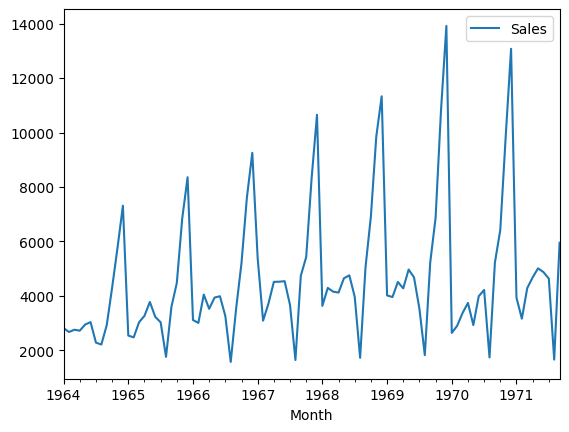

In [7]:
# line plots of times series
series.plot()
plt.show()

Some observations from the plot include:
- There may be an increasing trend of sales over time.
- There appears to be systematic seasonality to the sales for each year.
- The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
- There do not appear to be any obvious outliers.
- The seasonality suggests that the series is alomost certainly non-stationary.

There may be benefit in explicitly modeling the seasonal component and removing it. You may also explore using diﬀerencing with one or two levels in order to make the series stationary.
The increasing trend or growth in the seasonal component may suggest the use of a log or other power transform.

##### (3) Seasonal Line Plots

We can confirm the assumption that the seasonality is a yearly cycle by eyeballing line plots of the dataset by year.

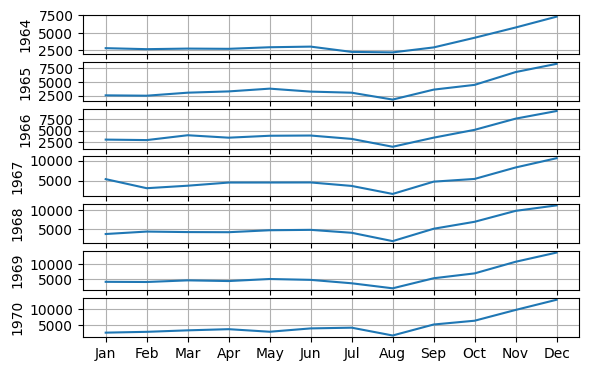

In [8]:
# multiple line plots of time series
df = pd.read_csv('dataset.csv')
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
df['MonthPeriod'] = df['Month'].dt.strftime('%b') # e.g. Jan, Feb, Mar
groups = df.groupby('Year')
years = pd.DataFrame()
plt.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
  if name != 1971:
    plt.subplot(n_groups*100 + 10 + i)
    i += 1
    plt.plot(group['MonthPeriod'], group['Sales'])
    plt.ylabel(name)
    plt.grid()
plt.show()

##### (4) Density Plots

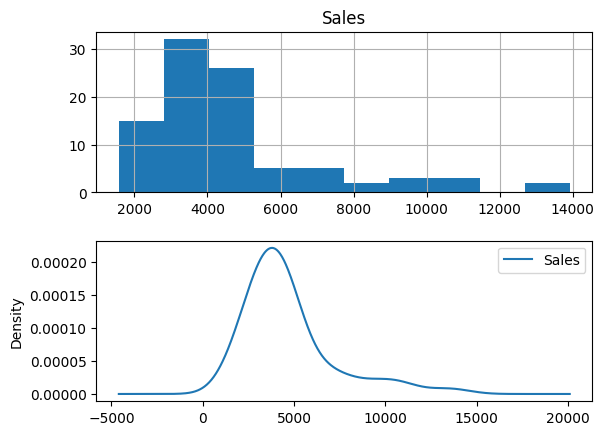

In [9]:
# density plots of time series
plt.figure()
plt.subplot(211)
series.hist(ax=plt.gca())
plt.subplot(212)
series.plot(kind='kde', ax=plt.gca())
plt.show()

Some observations from the plots include:
- The distribution is not Gaussian.
- The shape has a long right tail and may suggest an *exponential distribution*.

##### (5) Box and Whisker Plot

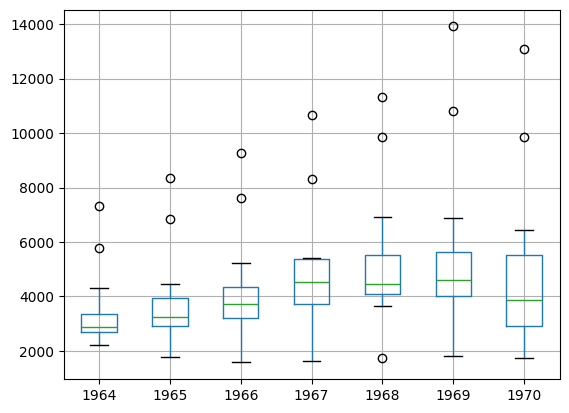

In [10]:
# boxplots of time series
df = pd.read_csv('dataset.csv')
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
df['MonthPeriod'] = df['Month'].dt.strftime('%b') # e.g. Jan, Feb, Mar
groups = df.groupby('Year')
years = pd.DataFrame()
for name, group in groups:
  if name != 1971:
    years[name] = group['Sales'].values
years.boxplot()
plt.show()


Some observations from reviewing the plots include:
- The median values for each yar may show an increasing trend.
- The spread or middle 50% of the data does appear reasonably stable.
- There are outliers earch year; these may be the tops or bottoms of the seasonal cycle.
- The last year, 1970, does look different from the trend in prior years.

The observations suggest perhaps some growth trend over the years and outliers that may be a part of the seasonal cycle. This yearly view of the data is an interesting avenue and could be pursued further by looking at summary statistics from year-to-year and changes in summary
stats from year-to-year.

#### 5. ARIMA Models

##### (1) Manually Configure the ARIMA

The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually. Analysis of the time series data assumes that we are working with a stationary time series. The time series is almost certainly non-stationary. We can make it stationary this by first
diﬀerencing the series and using a statistical test to confirm that the result is stationary.

The seasonality in the series is seemingly year-to-year. Seasonal data can be diﬀerenced by subtracting the observation from the same time in the previous cycle, in this case the same month in the previous year. This does mean that we will lose the first year of observations as
there is no prior year to diﬀerence with.

ADF Statistic: -7.135
p-value: 0.000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


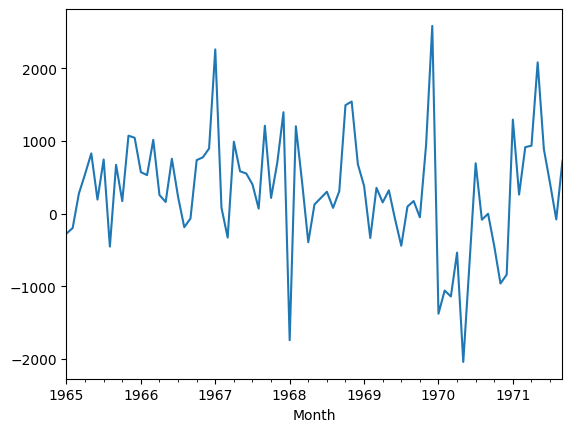

In [11]:
# create and summarize stationary version of time series

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
X = series['Sales'].astype(float).values
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')
print('Critical Values:')
for key, value in result[4].items():
  print(f'\t{key}: {value:.3f}')
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
plt.show()

The results show that the test statistic value -7.135 is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [12]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

A plot of the diﬀerenced dataset is also created. The plot does not show any obvious seasonality or trend, suggesting the seasonally diﬀerenced dataset is a good starting point for modeling. We will use this dataset as an input to the ARIMA model. It also suggests that no further diﬀerencing may be required, and that the d parameter may be set to 0.

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. *Note, we are now using the seasonally diﬀerenced stationary.csv as our dataset*. This is because the manual seasonal diﬀerencing performed is diﬀerent from the lag=1 diﬀerencing performed by the ARIMA model with the d parameter.

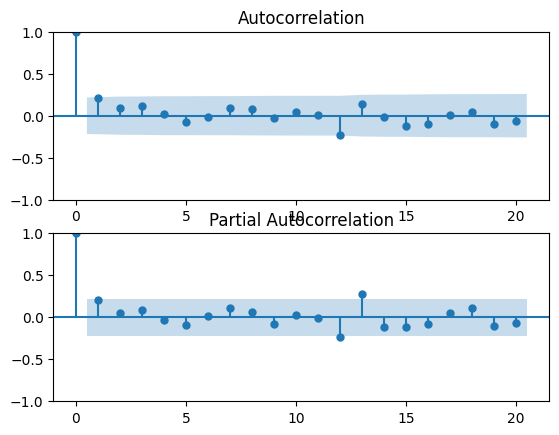

In [13]:
# ACF and PACF plots of time series
series = pd.read_csv('stationary.csv', index_col=0, parse_dates=True)
plt.figure()
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

Some observations from the plots:
- The ACF shows a significant lag for 1 month.
- The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months.
- Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

A good starting point for the p and q values is also 1. The PACF plot also suggests that there is still some seasonality present in the diﬀerenced data. We may consider a better model of seasonality, such as modeling it directly and explicitly removing it from the model rather than seasonal diﬀerencing.

This quick analysis suggests an ARIMA(1,0,1) on the stationary data may be a good starting point. The historic observations will be seasonally diﬀerenced prior to the fitting of each ARIMA model. The diﬀerencing will be inverted for all predictions made to make them directly
comparable to the expected observation in the original sale count units. Experimentation shows that this configuration of ARIMA does not converge and results in errors by the underlying library. Further experimentation showed that adding one level of diﬀerencing to the stationary data made the model more stable. The model can be extended to ARIMA(1,1,1).

We will also disable the automatic addition of a trend constant from the model by setting the trend argument to n for no constant.

In [14]:
# evaluate manually configured ARIMA model

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Sales'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(1,1,1), trend='n')
  model_fit = model.fit()
  yhat = model_fit.forecast().values[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')

>Predicted=8076.987, Expected=8314.000
>Predicted=9747.154, Expected=10651.000
>Predicted=5994.374, Expected=3633.000
>Predicted=3820.291, Expected=4292.000
>Predicted=4041.968, Expected=4154.000
>Predicted=4990.405, Expected=4121.000
>Predicted=5129.641, Expected=4647.000
>Predicted=5031.196, Expected=4753.000
>Predicted=4133.285, Expected=3965.000
>Predicted=2095.321, Expected=1723.000
>Predicted=5216.271, Expected=5048.000
>Predicted=5866.317, Expected=6922.000
>Predicted=8591.060, Expected=9858.000
>Predicted=11028.649, Expected=11331.000
>Predicted=4090.352, Expected=4016.000
>Predicted=4767.109, Expected=3957.000
>Predicted=4656.326, Expected=4510.000
>Predicted=4577.708, Expected=4276.000
>Predicted=5108.656, Expected=4968.000
>Predicted=5202.831, Expected=4677.000
>Predicted=4423.982, Expected=3523.000
>Predicted=2162.388, Expected=1821.000
>Predicted=5463.233, Expected=5222.000
>Predicted=7331.345, Expected=6872.000
>Predicted=10258.650, Expected=10803.000
>Predicted=11732.476

##### (2) Automatically Configure the ARIMA

In [16]:
# grid search ARIMA parameters for time series
import warnings
warnings.filterwarnings('ignore')

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype(float)
  train_size = int(len(X) * 0.50)
  train, test = X[:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    model = ARIMA(diff, order=arima_order, trend='n')
    model_fit = model.fit()
    yhat = model_fit.forecast().values[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    history.append(test[i])
  # calculate out of sample error
  rmse = np.sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype(float)
  best_score, best_cfg = float('inf'), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print(f'ARIMA {order} RMSE={rmse:.3f}')
        except:
          continue
  print(f'Best ARIMA {best_cfg} RMSE={best_score:.3f}')

# load dataset
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(series['Sales'].values, p_values, d_values, q_values)

ARIMA (0, 0, 0) RMSE=943.061
ARIMA (0, 0, 1) RMSE=939.478
ARIMA (0, 0, 2) RMSE=962.302
ARIMA (0, 1, 0) RMSE=1145.923
ARIMA (0, 1, 1) RMSE=959.122
ARIMA (0, 1, 2) RMSE=958.615
ARIMA (0, 2, 0) RMSE=1930.801
ARIMA (0, 2, 1) RMSE=1157.260
ARIMA (0, 2, 2) RMSE=958.330
ARIMA (1, 0, 0) RMSE=944.429
ARIMA (1, 0, 1) RMSE=941.123
ARIMA (1, 0, 2) RMSE=949.399
ARIMA (1, 1, 0) RMSE=1071.385
ARIMA (1, 1, 1) RMSE=961.619
ARIMA (1, 1, 2) RMSE=962.001
ARIMA (1, 2, 0) RMSE=1560.305
ARIMA (1, 2, 1) RMSE=1081.844
ARIMA (1, 2, 2) RMSE=966.612
ARIMA (2, 0, 0) RMSE=955.116
ARIMA (2, 0, 1) RMSE=946.674
ARIMA (2, 0, 2) RMSE=942.794
ARIMA (2, 1, 0) RMSE=1031.490
ARIMA (2, 1, 1) RMSE=971.915
ARIMA (2, 1, 2) RMSE=978.446
ARIMA (2, 2, 0) RMSE=1352.151
ARIMA (2, 2, 1) RMSE=1041.759
ARIMA (2, 2, 2) RMSE=1026.680
Best ARIMA (0, 0, 1) RMSE=939.478


We will select this ARIMA(0,0,1) going forward.

##### (3) Review Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean. We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(0,0,1) model.

                 0
count    47.000000
mean    165.889607
std     934.712850
min   -2164.244812
25%    -289.774839
50%     191.757926
75%     732.990413
max    2367.310317


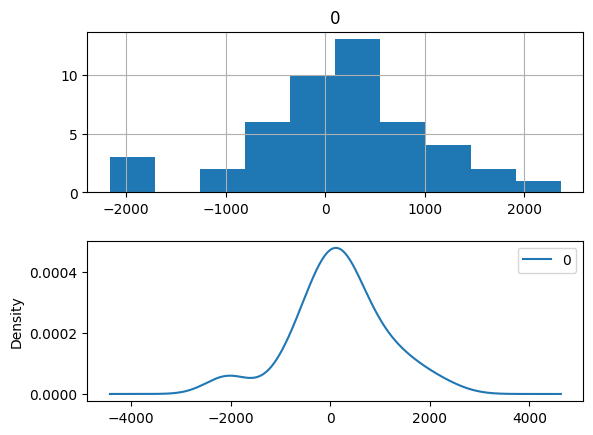

In [17]:
# summarize ARIMA forecast residuals

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Sales'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(0,0,1), trend='n')
  model_fit = model.fit()
  yhat = model_fit.forecast().values[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

We can see that the distribution has a right shift and that the mean is non-zero at 165.889607. This is perhaps a sign that the predictions are biased.

The distribution of residual errors is also plotted. The graphs suggest a Gaussian-like distribution with a bumpy left tail, providing further evidence that perhaps a power transform
might be worth exploring.

We could use this information to bias-correct predictions by adding the mean residual error of 165.889607 to each forecast made.

RMSE: 924.716
                  0
count  4.700000e+01
mean  -1.395846e-07
std    9.347129e+02
min   -2.330134e+03
25%   -4.556644e+02
50%    2.586832e+01
75%    5.671008e+02
max    2.201421e+03


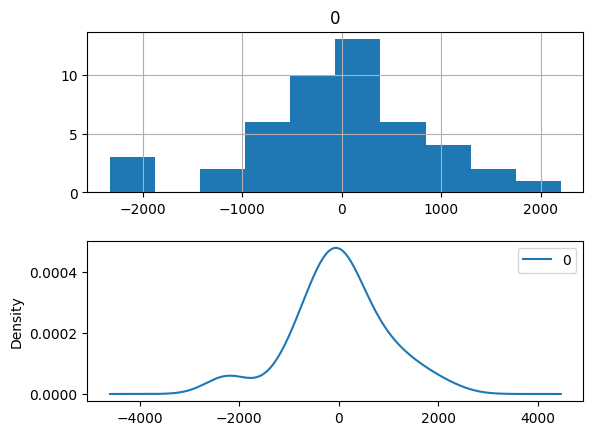

In [19]:
# plots of residual errors of bias corrected forecasts

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Sales'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.889607
for i in range(len(test)):
  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(0,0,1), trend='n')
  model_fit = model.fit()
  yhat = model_fit.forecast().values[0]
  yhat = inverse_difference(history, yhat, months_in_year) + bias
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')
# errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The performance of the predictions is improved very slightly from 939.478 to 924.716, which may or may not be significant. The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero.

Finally, density plots of the residual error do show a small shift towards zero. It is debatable whether this bias correction is worth it, but we will use it for now.

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data.

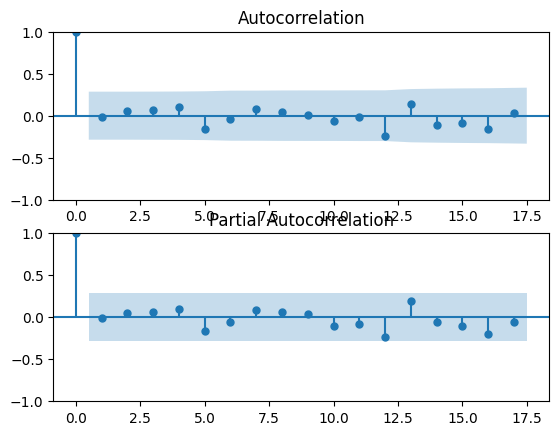

In [22]:
# ACF and PACF plots of residual errors of bias corrected forecasts
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

#### 6. Model Validation

##### (1) Finalize Model: Train and save the final model

In [23]:
# save finalized model

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Sales'].astype(float).values
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1), trend='n')
model_fit = model.fit()
# bias constant
bias = 165.889607
# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

##### (2) Make Prediction: Load the finalized model and make a prediction

In [25]:
# load finalized model and make a prediction

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
months_in_year = 12
model_fit_loaded = model_fit.load('model.pkl')
bias_loaded = np.load('model_bias.npy')
yhat = float(model_fit_loaded.forecast().values[0])
yhat = inverse_difference(series['Sales'].values, yhat, months_in_year) + bias_loaded[0]
print(f'Prediction: {yhat:.3f}')

Prediction: 6794.590


If we peek inside validation.csv, we can see that the value on the first row for the next time period is 6981. The prediction is in the right ballpark.

##### (3) Validate Model: Load and validate the final model

>Predicted=6794.590, Expected=6981.000
>Predicted=10101.724, Expected=9851.000
>Predicted=13219.075, Expected=12670.000
>Predicted=3996.586, Expected=4348.000
>Predicted=3465.807, Expected=3564.000
>Predicted=4522.651, Expected=4577.000
>Predicted=4901.287, Expected=4788.000
>Predicted=5190.078, Expected=4618.000
>Predicted=4930.177, Expected=5312.000
>Predicted=4944.766, Expected=4298.000
>Predicted=1699.396, Expected=1413.000
>Predicted=6085.309, Expected=5877.000
RMSE: 361.109


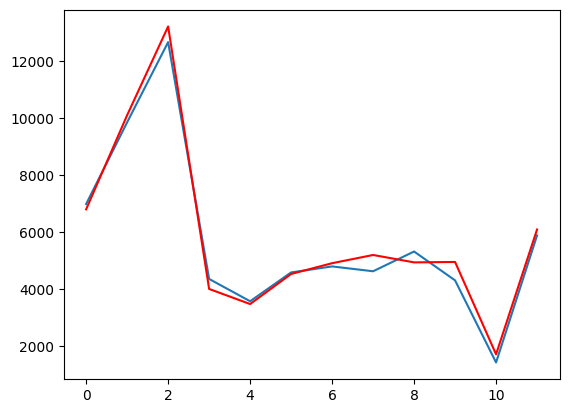

In [29]:
# load and evaluate the finalized model on the validation dataset

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load and prepare datasets
dataset = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
X = dataset['Sales'].astype(float).values
history = [x for x in X]
months_in_year = 12
validation = pd.read_csv('validation.csv', index_col=0, parse_dates=True)
y = validation['Sales'].astype(float).values
# load model
model_fit_loaded = model_fit.load('model.pkl')
bias_loaded = np.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit_loaded.forecast().values[0])
yhat = inverse_difference(history, yhat, months_in_year) + bias_loaded[0]
predictions.append(yhat)
history.append(y[0])
print(f'>Predicted={yhat:.3f}, Expected={y[0]:.3f}')
# rolling forecasts
for i in range(1, len(y)):
  # difference data
  diff = difference(history, months_in_year)
  # predict
  model = ARIMA(diff, order=(0,0,1), trend='n')
  model_fit = model.fit()
  yhat = float(model_fit.forecast().values[0])
  yhat = inverse_difference(history, yhat, months_in_year) + bias_loaded[0]
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')
# report performance
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse:.3f}')
# plot
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

The final RMSE for the validation period is predicted at 361.109 million
sales. This is much better than the expectation of an error of a little more than 924 million sales per month.

A plot of the predictions compared to the validation dataset is also provided. At this scale on the plot, the 12 months of forecast sales figures look fantastic.